# Readme

CS GO remains a very popular game for over 2 decades. Global Offensive has one of the most popular esport scenes in the world. The Global Offensive professional scene consists of leagues and tournaments hosted by third-party organizations, and Valve-sponsored tournaments known as Major Championships. Majors are considered the most prestigious tournaments in Counter-Strike circuit and have among the largest prize pools; originally announced at US 250,000, the prize pools for Majors have risen to USD 1,000,000 since MLG Columbus 2016. Like in physical sports, football, basketball etc., the betting on e-sport competitive events is becoming popular. This project is aimed for predicting outcomes of CS GO matches based on individual players' performance.

Files:
- CS GO prediction.ipynb - main notebook where the final output files were generated from
- CS GO playground for tests.ipynb - additional notebook to understand data and to play with ML models
- train.csv and players_feats.csv - data for training and crossvalidation
- test.csv - data for the test set

Output files:
These files includes the new column called 'who_win' for test.csv
- test_data_1
- test_data_2
- test_data_3

# Exploratory analysis

## Import data

In [1]:
import pandas as pd
import numpy as np

In [2]:
# import data and sort by map_id
players_feats = pd.read_csv('players_feats.csv')
players_feats.sort_values(by='map_id', inplace=True)
train_data = pd.read_csv('train.csv')
train_data.sort_values(by='map_id', inplace=True)
test_data = pd.read_csv('test.csv')

In [3]:
test_data.drop(columns=['index'], inplace=True)

## Process players_feats

In [4]:
players_feats.fillna(0, inplace=True)

In [5]:
players_feats.drop(columns=['p1_id', 'p2_id', 'p3_id', 'p4_id', 'p5_id'], inplace=True)

In [6]:
players_feats.shape

(1486, 123)

# Data analysis and processing

## Prepare for X and y

### Merge data

### For train data

In [7]:
# step 1 - merge with team 1
merged_df = pd.merge(train_data, players_feats, left_on = ['map_id', 'team1_id', 'map_name'], right_on =['map_id', 'team_id', 'map_name'])

# step 2 - merge with team 2
train_merged_df = pd.merge(merged_df, players_feats, left_on = ['map_id', 'team2_id', 'map_name'], right_on = ['map_id', 'team_id', 'map_name'], suffixes = ('_team_1', '_team_2'))
train_merged_df.shape

(713, 247)

### For test (exam) data

In [8]:
# step 1 - merge with team 1
merged_df = pd.merge(test_data, players_feats, left_on = ['map_id', 'team1_id', 'map_name'], right_on =['map_id', 'team_id', 'map_name'])

# step 2 - merge with team 2
test_merged_df = pd.merge(merged_df, players_feats, left_on = ['map_id', 'team2_id', 'map_name'], right_on = ['map_id', 'team_id', 'map_name'], suffixes = ('_team_1', '_team_2'))
test_merged_df.shape

(30, 246)

### X

In [9]:
# for train data 
X = train_merged_df.drop(columns=['map_id','map_name','who_win', 'team_id_team_1', 'team_id_team_2']);
# X = pd.get_dummies(X, columns = ['team1_id', 'team2_id'])
X.shape

(713, 242)

In [10]:
# for test (exam) data
X_test = test_merged_df.drop(columns=['map_id','map_name', 'team_id_team_1', 'team_id_team_2']);


In [11]:
X_concat = pd.concat([X, X_test])

In [12]:
X_concat.shape

(743, 242)

In [13]:
X_concat = pd.get_dummies(X_concat, columns = ['team1_id', 'team2_id'])
X_concat.shape

(743, 351)

In [14]:
X = X_concat.iloc[0:713,:]
X.shape

(713, 351)

In [15]:
X_test = X_concat.iloc[713:743,:]
X_test.shape

(30, 351)

In [16]:
# apply MinMaxScaler to make gradient descent effective
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X.values), columns=X.columns, index=X.index)
X_test = pd.DataFrame(scaler.fit_transform(X_test.values), columns=X_test.columns, index=X_test.index)

In [17]:
X.shape

(713, 351)

In [18]:
X_test.shape

(30, 351)

### y

In [19]:
y = train_merged_df['who_win']

# Creation of ANN

The idea is to create ensemble of ANNs. Because those results are more stable. Accuracy do not change as much over multiple runs. There are better ways to put ensemble on ANNs than implemented here, however, this code does the job.

## ANN

In [20]:
import copy
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras import regularizers

In [21]:
%%capture
score_acc = []

for i in range(0,30):
    
    # create model and execute it
    X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=30/713)

    no_inputs_X = X_train.shape[1]

    model_ANN = keras.Sequential([
        keras.layers.Dense(3, activation='tanh', input_shape=(no_inputs_X,), kernel_regularizer=regularizers.l2(0.001)),
        keras.layers.Dense(2, activation='tanh', kernel_regularizer=regularizers.l2(0.001)),
        keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001))
    ])

    model_ANN.compile(optimizer = 'adam',
                  loss = 'binary_crossentropy',
                  metrics = ['accuracy'])

    
    model_ANN.fit(X_train, y_train, epochs=500);

    test_loss, test_accuracy = model_ANN.evaluate(X_train, y_train)

    test_loss, test_accuracy = model_ANN.evaluate(X_cv, y_cv)
    
    score_acc.append(test_accuracy)
    
    
    
    # predict results for the test (exam) set       
    b1 = model_ANN.predict(X)
    b2 = model_ANN.predict(X_test)

    if i == 0:
        a1 = copy.deepcopy(b1)
        a2 = copy.deepcopy(b2)

    a1 = np.concatenate((a1,b1), axis=1)
    a2 = np.concatenate((a2,b2), axis=1)


### Output for scores

In [22]:
np.mean(score_acc)

0.5966666708389918

In [23]:
score_acc

[0.6000000238418579,
 0.46666666865348816,
 0.6333333253860474,
 0.5333333611488342,
 0.7666666507720947,
 0.5,
 0.4333333373069763,
 0.6000000238418579,
 0.5666666626930237,
 0.6333333253860474,
 0.699999988079071,
 0.6000000238418579,
 0.7333333492279053,
 0.6000000238418579,
 0.6333333253860474,
 0.6333333253860474,
 0.6666666865348816,
 0.6333333253860474,
 0.5666666626930237,
 0.699999988079071,
 0.5,
 0.7333333492279053,
 0.6333333253860474,
 0.5666666626930237,
 0.5333333611488342,
 0.4333333373069763,
 0.6333333253860474,
 0.5666666626930237,
 0.5333333611488342,
 0.5666666626930237]

In [24]:
# manually saved mean scores over multiple runs of this notebook
[0.6267, 0.5989, 0.5967]

(0.6267, 0.5989)

### Output for predictions for test (exam) set

In [25]:
# predictions for all data from train.csv
y_pred = np.delete(a1,0,1)
y_pred.shape

(713, 30)

In [26]:
# predictions for test exam data
y_test_pred = np.delete(a2,0,1)
y_test_pred.shape

(30, 30)

In [27]:
y_pred = np.sum(y_pred, axis=1) / y_pred.shape[1]
y_pred.shape

(713,)

In [28]:
y_true = np.array(y)
y_true.shape

(713,)

In [29]:
y_test_pred = np.sum(y_test_pred, axis=1) / y_test_pred.shape[1]
y_test_pred.shape

(30,)

# ROC curve and optimal threshold

In [30]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [37]:
auc = np.round(roc_auc_score(y_true, y_pred), 4)

In [38]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

Text(0.5, 1.0, 'AUC score 0.9718')

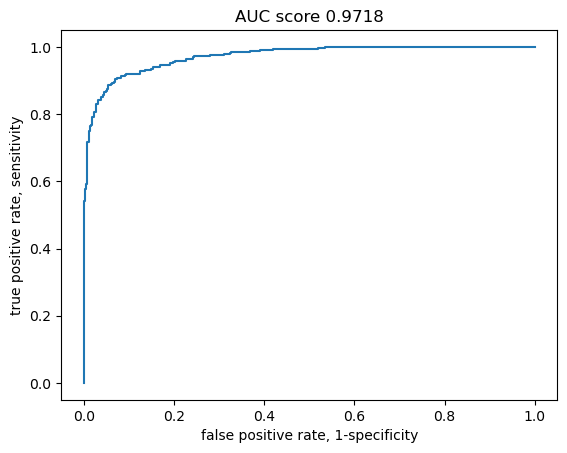

In [39]:
import matplotlib.pyplot as plt

plt.plot(fpr,tpr)
plt.xlabel('false positive rate, 1-specificity')
plt.ylabel('true positive rate, sensitivity')
plt.title(f'AUC score {auc}')

## Optimal threshold

Optimal threshold can be found by maximizing sensitivity + specificity.

In [34]:
ind_max = np.argmax(tpr + (1 - fpr))

In [35]:
best_threshold = thresholds[ind_max]
best_threshold

0.48298475

In [36]:
# manually saved best threshold over multiple runs of this notebook
[0.4793, 0.4649, 0.4830]

(0.4793, 0.4649)

## Calculate values for the test set

In [76]:
# prediction values
y_test_pred

array([0.15076722, 0.00538533, 0.01990731, 0.08268661, 0.00453799,
       0.03199288, 0.02432018, 0.12169353, 0.11167125, 0.14454032,
       0.00681516, 0.55254585, 0.5285141 , 0.05352344, 0.02455742,
       0.37433484, 0.6863726 , 0.8019112 , 0.01610186, 0.11562748,
       0.03523869, 0.2517117 , 0.48393616, 0.02381004, 0.01175389,
       0.5041905 , 0.62440145, 0.9920829 , 0.62974554, 0.4893617 ],
      dtype=float32)

In [81]:
y_answer = []

threshold = 0.4830
for i in y_test_pred:
    
    if i >= threshold:
        y_answer.append(1)
    elif i < threshold:
        y_answer.append(0)

In [82]:
len(y_test_values)

30

In [83]:
test_data['who_win'] = y_answer

In [84]:
test_data.to_csv('test_data_3.csv', index=False)